<a href="https://colab.research.google.com/github/kushv16/Audio-Sentiment-Analysis/blob/master/AlexNet_%7C_2D_MFCC_features_%7C_Without_CremaD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# import libraries
import pandas as pd
import numpy as np
import librosa
import librosa.display
import random
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
%matplotlib inline
%config InlineBackend.figure_format='retina'
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  

In [3]:
!pip install tqdm

from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
df = pd.read_csv('/content/drive/MyDrive/LY Project/Result and Analysis/CNN Results | 2D MFCCs | Without CremaD/combo_with_cleaned_paths.csv', index_col=0)


df.sample()

,path,filename,dataset,duration,sample_rate,gender,age,emotion,f0_mean,f0_median,...,mfcc22_var,mfcc23_var,mfcc24_var,mfcc25_var,mfcc26_var,mfcc27_var,mfcc28_var,mfcc29_var,mfcc30_var,mfccs
12339,/content/drive/MyDrive/LY Project/Cleaned Data...,female2_neutral_12a_2_cleaned.wav,JL-Corpus,1.65,44100,female,30,neutral,158.921087,157.825829,...,34.77934,16.365849,23.306627,21.820951,22.950708,14.079849,15.754153,20.246517,15.402141,[[-739.3859 -647.59534 -588.41925 ... -...


In [8]:
df = df[df['dataset'] != 'CREMA-D']
df = df.reset_index(drop=True)

In [9]:
df.shape

(9343, 98)

In [10]:
# Select target
df['emotion'].replace({'angry':0,'disgust':1,'fear':2,'happy':3,'neutral':4,'sad':5,'surprise':6}, inplace=True)
y = df.emotion.values



In [11]:
x_tr = np.load('/content/drive/MyDrive/LY Project/Result and Analysis/CNN Results | 2D MFCCs | Without CremaD/x_tr.npy')
x_va = np.load('/content/drive/MyDrive/LY Project/Result and Analysis/CNN Results | 2D MFCCs | Without CremaD/x_va.npy')
x_te = np.load('/content/drive/MyDrive/LY Project/Result and Analysis/CNN Results | 2D MFCCs | Without CremaD/x_te.npy')

y_tr = np.load('/content/drive/MyDrive/LY Project/Result and Analysis/CNN Results | 2D MFCCs | Without CremaD/y_tr.npy')
y_va = np.load('/content/drive/MyDrive/LY Project/Result and Analysis/CNN Results | 2D MFCCs | Without CremaD/y_va.npy')
y_te = np.load('/content/drive/MyDrive/LY Project/Result and Analysis/CNN Results | 2D MFCCs | Without CremaD/y_te.npy')


In [12]:
x_tr.shape, x_va.shape, x_te.shape, y_tr.shape, y_va.shape, y_te.shape

((5885, 30, 200), (2523, 30, 200), (935, 30, 200), (5885,), (2523,), (935,))

In [13]:
# Get mean and standard deviation from the training set
tr_mean = np.mean(x_tr, axis=0)
tr_std = np.std(x_tr, axis=0)

# Apply data scaling
x_tr = (x_tr - tr_mean)/tr_std
x_va = (x_va - tr_mean)/tr_std
x_te = (x_te - tr_mean)/tr_std

In [14]:
# Add the 'channel' dimension to the MFCCs spectrum input 'images'
print(f"x_tr has a dimension of {x_tr.shape} before the manipulation.")

x_tr = x_tr[..., None]
x_va = x_va[..., None]
x_te = x_te[..., None]

print(f"x_tr has a dimension of {x_tr.shape} after the manipulation.")

x_tr has a dimension of (5885, 30, 200) before the manipulation.
x_tr has a dimension of (5885, 30, 200, 1) after the manipulation.


In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization

model = Sequential()

# Layer 1
model.add(Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), padding='same', input_shape=(30,200,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))
model.add(BatchNormalization())

# Layer 2
model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))
model.add(BatchNormalization())

# Layer 3
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Layer 4
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Layer 5
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))
model.add(BatchNormalization())

# Flatten and add fully connected layers
model.add(Flatten())
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

# Output layer
model.add(Dense(units=7, activation="softmax"))

# Print the model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 8, 50, 96)         11712     
                                                                 
 activation_5 (Activation)   (None, 8, 50, 96)         0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 25, 96)        0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 4, 25, 96)        384       
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 4, 25, 256)        614656    
                                                                 
 activation_6 (Activation)   (None, 4, 25, 256)       

In [19]:
from tensorflow import keras

# Compile the model using Adam's default learning rate
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_tr), y= y_tr)
class_weights = dict(zip(np.unique(y_tr), class_weights))

# Create 'EarlyStopping' callback
earlystopping_cb = keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True)

In [20]:
%%time

#  Trains the neural network
history = model.fit(
    x=x_tr,
    y=y_tr,
    epochs=1000,
    batch_size=32,
    validation_data=(x_va, y_va),
    callbacks=[earlystopping_cb],
    class_weight=class_weights,
)

Epoch 1/1000
184/184 [==============================] - 25s 36ms/step - loss: 1.9839 - accuracy: 0.4116 - val_loss: 2.1710 - val_accuracy: 0.4554
Epoch 2/1000
184/184 [==============================] - 4s 23ms/step - loss: 1.3460 - accuracy: 0.5825 - val_loss: 2.2084 - val_accuracy: 0.3730
Epoch 3/1000
184/184 [==============================] - 4s 24ms/step - loss: 0.9731 - accuracy: 0.7003 - val_loss: 1.3463 - val_accuracy: 0.5953
Epoch 4/1000
184/184 [==============================] - 4s 20ms/step - loss: 0.8845 - accuracy: 0.7186 - val_loss: 1.6746 - val_accuracy: 0.5038
Epoch 5/1000
184/184 [==============================] - 4s 20ms/step - loss: 0.8024 - accuracy: 0.7451 - val_loss: 1.3993 - val_accuracy: 0.6750
Epoch 6/1000
184/184 [==============================] - 4s 21ms/step - loss: 0.6861 - accuracy: 0.7772 - val_loss: 1.4441 - val_accuracy: 0.5347
Epoch 7/1000
184/184 [==============================] - 5s 25ms/step - loss: 0.6062 - accuracy: 0.8080 - val_loss: 0.5743 - val_a

In [21]:
hist_df = pd.DataFrame(history.history) 
hist_df.to_csv("/content/drive/MyDrive/LY Project/alexnet_history.csv")

model.save_weights("/content/drive/MyDrive/LY Project/alexnet_weights.h5")

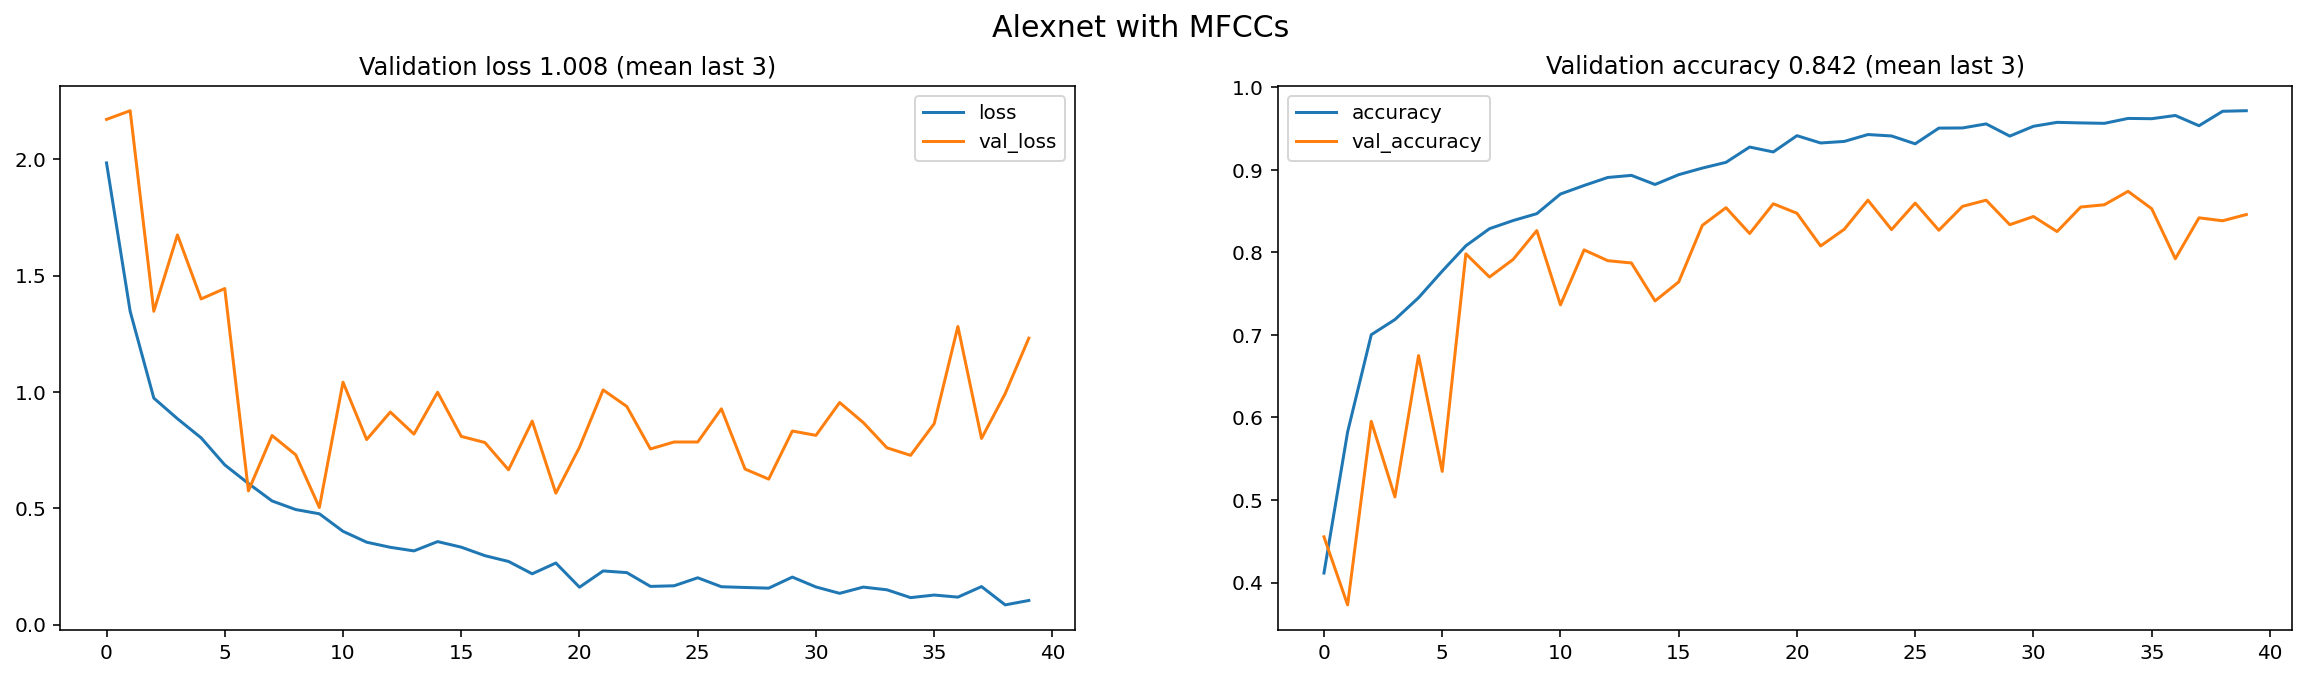

In [22]:
# Plots neural network performance metrics for train and validation
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
plt.suptitle('Alexnet with MFCCs', size=15)
results = pd.DataFrame(history.history)
results[["loss", "val_loss"]].plot(ax=axs[0])
axs[0].set_title("Validation loss {:.3f} (mean last 3)".format(np.mean(history.history["val_loss"][-3:])))
results[["accuracy", "val_accuracy"]].plot(ax=axs[1])
axs[1].set_title("Validation accuracy {:.3f} (mean last 3)".format(np.mean(history.history["val_accuracy"][-3:])))
plt.savefig("/content/drive/MyDrive/LY Project/alexnet_training_curves.png")
plt.show()

In [23]:
# Collect loss and accuracy for the test set
loss_te, accuracy_te = model.evaluate(x_te, y_te)

print("Test loss: {:.2f}".format(loss_te))
print("Test accuracy: {:.2f}%".format(100 * accuracy_te))

30/30 [==============================] - 0s 13ms/step - loss: 0.4742 - accuracy: 0.8396
Test loss: 0.47
Test accuracy: 83.96%


30/30 [==============================] - 0s 5ms/step


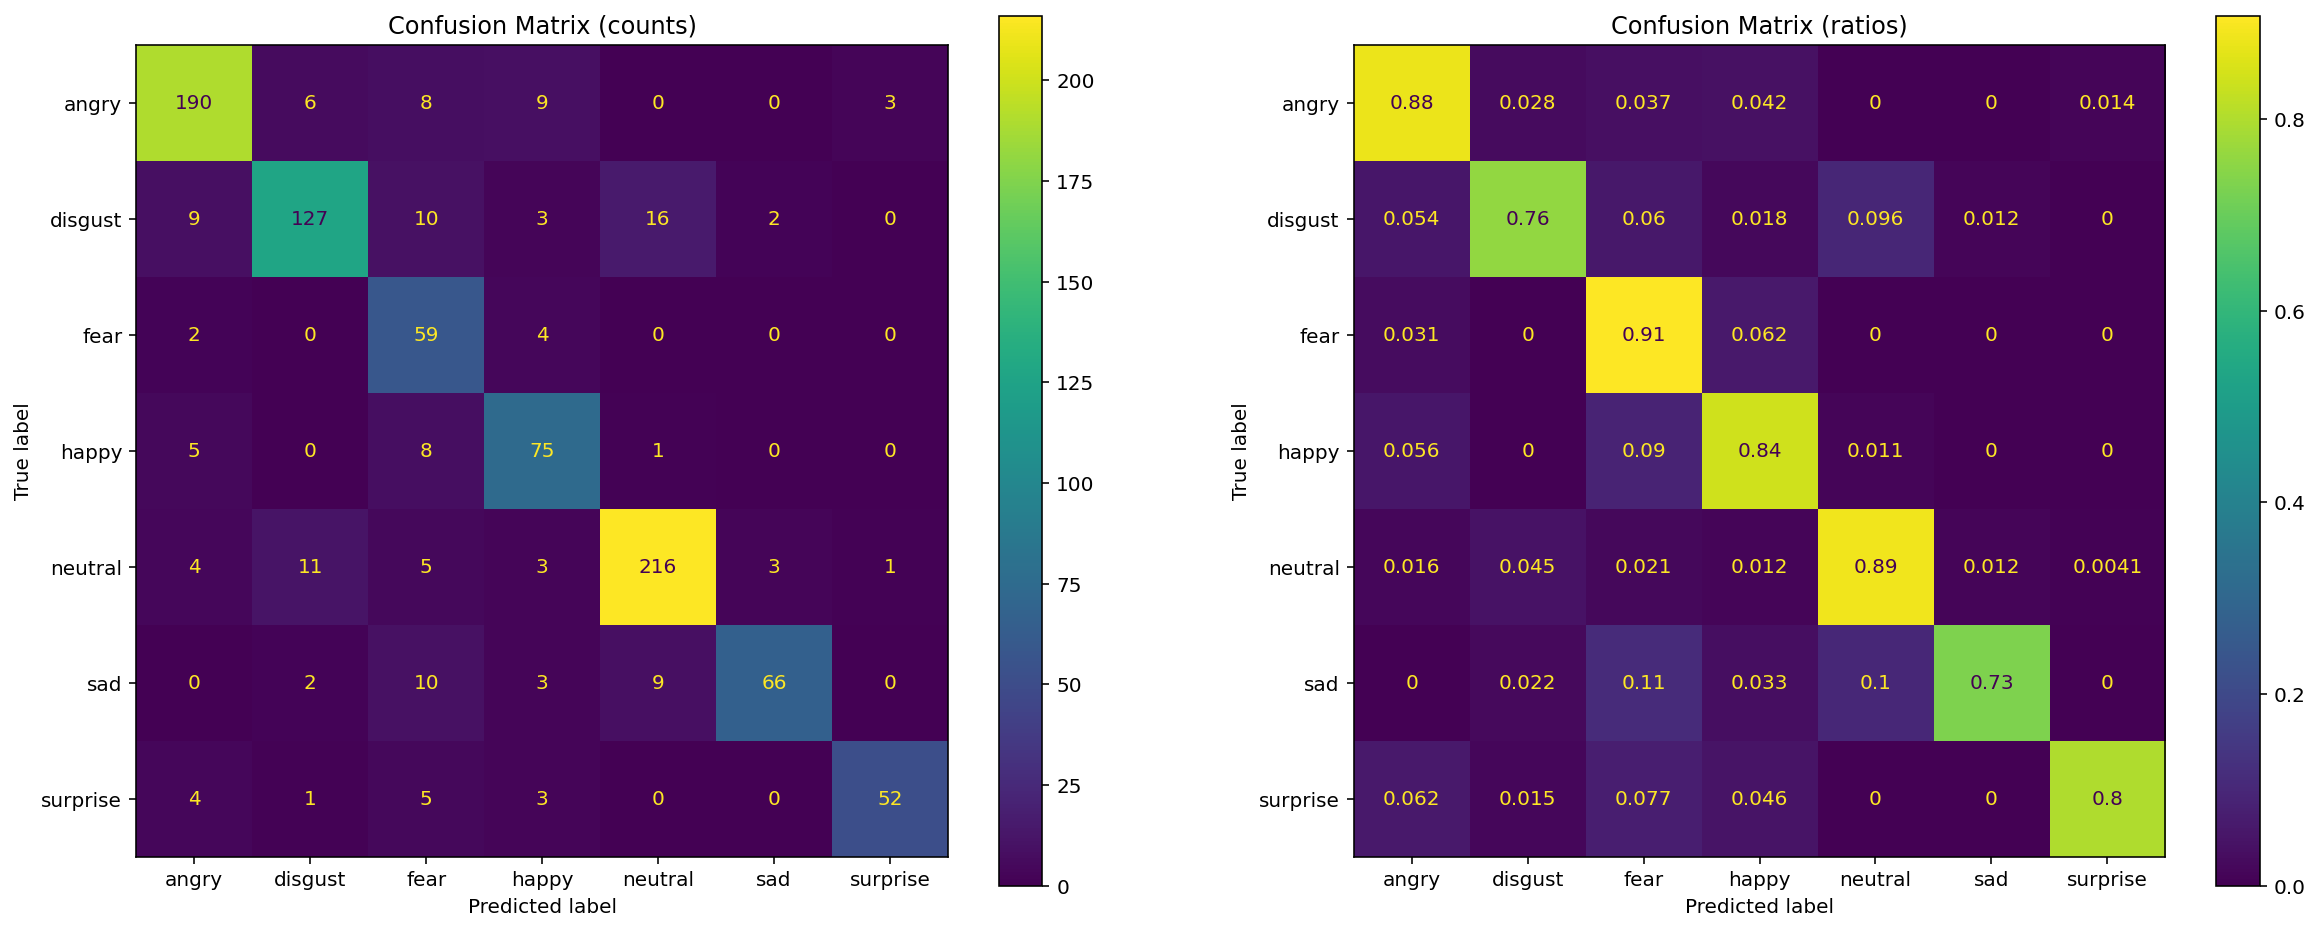

In [24]:
# Compute test set predictions
predictions = model.predict(x_te)

pred = []

for i in predictions:
    pred.append(np.argmax(i))
    
from sklearn.metrics import ConfusionMatrixDisplay

labels = {'angry':0,'disgust':1,'fear':2,'happy':3,'neutral':4,'sad':5,'surprise':6}

def plot_confusion_matrices(y_true, y_pred):

    # Create two subplots
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plots the standard confusion matrix
    ax1.set_title("Confusion Matrix (counts)")
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels, ax=ax1)

    # Plots the normalized confusion matrix
    ax2.set_title("Confusion Matrix (ratios)")
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels, normalize="true", ax=ax2)
    plt.savefig("/content/drive/MyDrive/LY Project/alexnet_confusion_matrices.png")
    plt.show()

# Plot confusion matrices
plot_confusion_matrices(y_te, pred)